# New York City Taxi Fare Prediction Playground Competition 


## Abstract

This is a playground competition on New York City Taxi Fare Prediction with a dataset of 44M rows. For better analysis and saving up the memory I have used limited data which are important for prediction. Here I am supposed to predict the taxi fare amount (inclusive of tolls) given the pickup and dropoff locations. I can get an estimation on just the distance between the two points and other features like datetime and passenger count. I have derived absolute travel vector features in both latitude and longitude co-ordinates for setting up the training data. For data cleaning purpose I dropped the NaN values and the features which show less correlation with the predicting feature using corrplot and heatmap. I removed the negative taxi fares, passenger count more than 6 or 0 and the longitude/latitude values which are out of range. A scatter plot of the trained absolute values is plotted to check the outliers in them and hence I removed them. I plotted the training data points on a map for visualization purpose. For better data preprocessing, I calculated the manhattan and euclidean distance and converted them into kilometer and the minimum and maximum distance values. I also notice that the longer the distance the more the fare and the taxi fare to airports is more especially during the night time. So I divided the time into morning, afternoon, evening and late night and also weekend or not. This will give me more insight in the analysis of the taxi fare. To make the predictions better I  have performed linear regression, random forest regression , neural network and gradient boosting for parameter tuning using tensorflow. These methods helps to reduce the Root Mean Square Error value and give accurate results for the best model.

In [16]:
# Initial Python environment setup...
import numpy as np # linear algebra
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
import os # reading the input files we have access to
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize,MinMaxScaler
%matplotlib inline
import math
from matplotlib import pyplot as plt
from datetime import datetime
from keras.callbacks import LearningRateScheduler
# from google.colab import drive
# drive.mount('/content/gdrive')

#imports
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from keras import layers

# print(os.listdir('./gdrive/My Drive/'))
training=True

### Setup training data
First let's read in our training data.  

In [85]:
if training:
     train_df =  pd.read_csv('./new-york-city-taxi-fare-prediction/train.csv', nrows = 15_000_000)
else:
    train_df = pd.read_csv('./new-york-city-taxi-fare-prediction/test.csv')


Let's create two new features in our training set representing the "travel vector" between the start and end points of the taxi ride, in both longitude and latitude coordinates.  We'll take the absolute value since we're only interested in distance traveled. Use a helper function since we'll want to do the same thing for the test set later.

In [86]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

### Data Operations
First let's see if there are any `NaN`s in the dataset.

In [87]:
print(train_df.isnull().sum())

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude     99
dropoff_latitude      99
passenger_count        0
abs_diff_longitude    99
abs_diff_latitude     99
dtype: int64


There are a small amount, so let's remove them from the dataset.

In [88]:
print('Old size: %d' % len(train_df))
if training:
    train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 15000000
New size: 14999901


Now let's quickly plot a subset of our travel vector features to see its distribution.

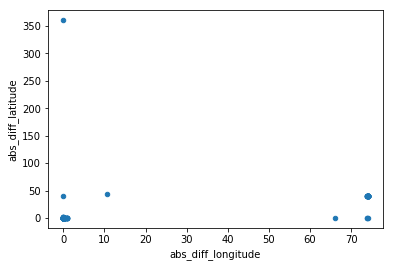

In [89]:
plot= train_df.iloc[:20000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

We expect most of these values to be very small (likely between 0 and 1) since it should all be differences between GPS coordinates within one city.  For reference, one degree of latitude is about 69 miles.  However, we can see the dataset has extreme values which do not make sense.  Let's remove those values from our training set. Based on the scatterplot, it looks like we can safely exclude values above 5 (though remember the scatterplot is only showing the first 2000 rows...)

In [90]:
print('Old size: %d' % len(train_df))
if training:
    train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df))

Old size: 14999901
New size: 14968927


In [91]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754



### Train our model
 Considering only the selected values in the training data:
 1. Passenger count which is less than 6 makes sense
 2. Positive fare amount values
 3. Fare amount less  than 250
 4. Airport co-ordinates

In [92]:
if training:
    train_df = train_df[train_df["passenger_count"] < 6]
    train_df_1 = train_df[train_df["fare_amount"] > 0]

    train_df_1 = train_df_1[train_df["fare_amount"] < 250]
    jfk = (-73.7822222222, 40.6441666667) #JFK Airport
    ewr = (-74.175, 40.69) # Newark Liberty International Airport
    lgr = (-73.87, 40.77) # LaGuardia Airport





    data = train_df_1[(train_df_1.abs_diff_longitude < 3.0) & (train_df_1.abs_diff_latitude < 3.0)]
    data = data[(data.pickup_longitude >= -74.3) & (data.pickup_longitude <= -72.9)]  # nyc coordinates
    data = data[(data.dropoff_longitude >= -74.3) & (data.dropoff_longitude <= -72.9)]
    data = data[(data.pickup_latitude >= 40.5) & (data.pickup_latitude <= 41.8)]
    data = data[(data.dropoff_latitude >= 40.5) & (data.dropoff_latitude <= 41.8)]
    train_df_1 = data

/Users/manushpatel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [93]:
train_df_1 = train_df

In [94]:
train_df_1.size

146522760

In [95]:
train_df_abs_diffs = train_df_1
    

x_data = train_df_abs_diffs[["abs_diff_longitude","abs_diff_latitude","passenger_count","pickup_datetime",
                             'pickup_latitude',"pickup_longitude","dropoff_latitude","dropoff_longitude"]]
if training:
    y_data = train_df_abs_diffs["fare_amount"]

### Data Preprocessing

Implementing various functions to calculate the distance between the pickup latitude, longitude points and dropff latitude, longitude points. 
Also , we have encoding for time where we have splitted the 24 hour clock into 4 parts i.e morning, afternoon,  evening and late night as at each time the fares are different. Year,month and day are also considered as weekend rates are more especially while for the airport locations.


In [96]:
#lambdas

#print(data.describe())
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...
  
def calc_sin_square(x):
    return math.sin(math.radians(x/2)) ** 2

def calc_c(x):
    return math.atan2(math.sqrt(x),math.sqrt(1-x))

def act_distance(x):
    return 6371 * x

def label_time(x):
    return x.split(" ")[1][:2]

def encode_time(x):
    a = int(x)
    if a >=0 and a<=6:
        return 1
    elif a>6 and a <=12:
        return 2
    elif a>12 and a<=18:
        return 3
    elif a>18 and a<=24:
        return 4
def late_night_calc(x):
    a = int(x.split(" ")[1][:2])
    if a >= 22 or a<=6:
        return 1
    else:
        return 0
def weekend_or_not(x):
    date = x.split(" ")[0]
    weekno = datetime.strptime(date,"%Y-%m-%d").weekday()
    if weekno < 5:
        return 0
    else:
        return 1
def year(x):
    date = x.split(" ")[0]
    year = datetime.strptime(date,"%Y-%m-%d").year
    return year
def month(x):
    date = x.split(" ")[0]
    month = datetime.strptime(date,"%Y-%m-%d").month
    return month
def date(x):
    date = x.split(" ")[0]
    month = datetime.strptime(date,"%Y-%m-%d").day
    return month
    
def exp_decay(epoch):
    return epoch ** 0.095

### Distance conversion lat,long to km

In [97]:
x_data["a_lat"] = x_data["abs_diff_latitude"].apply(calc_sin_square)
x_data["a_long"] = x_data["abs_diff_longitude"].apply(calc_sin_square)
x_data["c_lat"] = x_data["a_lat"].apply(calc_c)
x_data["c_long"] = x_data["a_long"].apply(calc_c)
x_data["lat_dist"]  = x_data["c_lat"].apply(act_distance)
x_data["long_dist"] = x_data["c_long"].apply(act_distance)
x_data["distance_km"] = x_data["lat_dist"] + x_data["long_dist"]

/Users/manushpatel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Adding more features in the model like pickup and dropoff at popular places of New York where. passengers travels the most for better predictions.

In [98]:
nyc = (-74.0063889, 40.7141667)
 # county
Nassau = (-73.5594, 40.6546)
Suffolk = (-72.6151, 40.9849)
Westchester = (-73.7949, 41.1220)
Rockland = (-73.9830, 41.1489)
Dutchess = (-73.7478, 41.7784)
Orange = (-74.3118, 41.3912)
Putnam = (-73.7949, 41.4351) 
x_data['distance_to_center'] = distance(nyc[1], nyc[0],x_data.dropoff_latitude, x_data.dropoff_longitude)
x_data["pickup_nyc"] = distance(nyc[1], nyc[0],x_data.pickup_latitude, x_data.pickup_longitude)
x_data["pickup_jfk"] = distance(jfk[1], jfk[0],x_data.pickup_latitude, x_data.pickup_longitude)
x_data["pickup_ewr"] = distance(ewr[1], ewr[0],x_data.pickup_latitude, x_data.pickup_longitude)
x_data["pickup_lgr"] = distance(lgr[1], lgr[0],x_data.pickup_latitude, x_data.pickup_longitude)
x_data["dropoff_nass"] = distance(Nassau[1], Nassau[0],x_data.dropoff_latitude, x_data.dropoff_longitude)
x_data["dropoff_suff"] = distance(Suffolk[1], Suffolk[0],x_data.dropoff_latitude, x_data.dropoff_longitude)
x_data["dropoff_west"] = distance(Westchester[1], Westchester[0],x_data.dropoff_latitude, x_data.dropoff_longitude)
x_data["dropoff_rock"] = distance(Rockland[1], Rockland[0],x_data.dropoff_latitude, x_data.dropoff_longitude)
x_data["dropoff_dutc"] = distance(Dutchess[1], Dutchess[0],x_data.dropoff_latitude, x_data.dropoff_longitude)
x_data["dropoff_oran"] = distance(Orange[1], Orange[0],x_data.dropoff_latitude, x_data.dropoff_longitude)
x_data["dropoff_putn"] = distance(Putnam[1], Putnam[0],x_data.dropoff_latitude, x_data.dropoff_longitude)
x_data["pickup_nass"] = distance(Nassau[1], Nassau[0],x_data.pickup_latitude, x_data.pickup_longitude)
x_data["pickup_suff"] = distance(Suffolk[1], Suffolk[0],x_data.pickup_latitude, x_data.pickup_longitude)
x_data["pickup_west"] = distance(Westchester[1], Westchester[0],x_data.pickup_latitude, x_data.pickup_longitude)
x_data["pickup_rock"] = distance(Rockland[1], Rockland[0],x_data.pickup_latitude, x_data.pickup_longitude)
x_data["pickup_dutc"] = distance(Dutchess[1], Dutchess[0],x_data.pickup_latitude, x_data.pickup_longitude)
x_data["pickup_oran"] = distance(Orange[1], Orange[0],x_data.pickup_latitude, x_data.pickup_longitude)
x_data["pickup_putn"] = distance(Putnam[1], Putnam[0],x_data.pickup_latitude, x_data.pickup_longitude)



### Time conversion from string to label 1,2,3,4 & weekend or not & late night or not

In [99]:
x_data["time_label"] = x_data["pickup_datetime"].apply(label_time)
x_data["time"] = x_data["time_label"].apply(encode_time)



x_data["late_night"] = x_data["pickup_datetime"].apply(late_night_calc)
x_data["weekend"] = x_data["pickup_datetime"].apply(weekend_or_not)
x_data["year"] = x_data["pickup_datetime"].apply(year)
x_data["date"] = x_data["pickup_datetime"].apply(date)
x_data["month"] = x_data["pickup_datetime"].apply(month)

In [100]:
x_data = x_data.drop(["passenger_count","a_lat","dropoff_latitude","pickup_latitude","pickup_longitude","pickup_latitude",
                      "a_long","c_lat","c_long","lat_dist","time_label","pickup_datetime","long_dist"],axis=1)

In [101]:
if training:
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)
    print(len(X_test),len(X_train),len(y_test),len(y_train))
else:
    X_test = x_data

2930456 11721820 2930456 11721820


In [102]:
X_train.dtypes

abs_diff_longitude    float64
abs_diff_latitude     float64
dropoff_longitude     float64
distance_km           float64
distance_to_center    float64
pickup_nyc            float64
pickup_jfk            float64
pickup_ewr            float64
pickup_lgr            float64
dropoff_nass          float64
dropoff_suff          float64
dropoff_west          float64
dropoff_rock          float64
dropoff_dutc          float64
dropoff_oran          float64
dropoff_putn          float64
pickup_nass           float64
pickup_suff           float64
pickup_west           float64
pickup_rock           float64
pickup_dutc           float64
pickup_oran           float64
pickup_putn           float64
time                    int64
late_night              int64
weekend                 int64
year                    int64
date                    int64
month                   int64
dtype: object

## Model 1

### Linear Regression

In [36]:
if training:
    regr = linear_model.LinearRegression(normalize = True)
    regr.fit(X_train,y_train)

In [37]:
if training:
    y_pred = regr.predict(X_test)
else:
    y_pred = regr.predict(x_data)
    

In [38]:
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Root Mean squared error: %.2f"
      % math.sqrt(mean_squared_error(y_test, y_pred)))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [-9.17908658e+12 -9.17908658e+12  4.07118551e-03  1.65099018e+11
  7.95934089e-01  1.20764990e+00 -3.52910961e-01 -2.68049272e+00
  3.64837284e-01  1.05481853e-01 -1.52754422e+00 -1.36798256e+00
  7.95920090e+00  5.01349192e+00 -6.77126485e+00 -4.50900521e+00
 -5.10982766e-01  2.75560247e+00 -4.66039531e+00 -4.44593340e+00
 -8.33648329e+00  9.29042365e+00  7.67301406e+00 -2.55934112e-02
 -2.68830941e-01 -2.24058928e-01  5.46332135e-01  1.82988227e-03
  8.37812088e-02]
Root Mean squared error: 6.15
Variance score: 0.61


## Model 2

### Random Forest

Using ensemble method we train multiple models using the same learning algorithm. It helps to minimize noise, bias variance. A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of a data set to improve the predictive accuracy and control over fitting. 

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=200,)

In [ ]:
y_pred = regr.predict(X_test)

In [ ]:
regr.score(X_test,y_test)


In [ ]:
error = abs(y_pred - y_test)

In [0]:
np.mean(100 * (error / y_test))

34.83531437371066

In [0]:
meanSquaredError=mean_squared_error(y_test,y_pred)
math.sqrt(meanSquaredError)

5.642046290748097

## Model 3

### Neural network Basic

We normalize the input layer by adjusting and scaling the activations. Batch normalization reduces the amount by what the hidden unit values shift around (covariance shift). It reduces overfitting because it has a slight regularization effects. Similar to dropout, it adds some noise to each hidden layer’s activations. 

In [0]:
#build our model
model = Sequential()

model.add(Dense(512))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(Dense(32))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [0]:
model.fit(
    X_train.values,
    y_train.values,
    batch_size= 4096,
    epochs=50,
    shuffle=True,
    verbose=1
)

Epoch 1/50
7814316/7814316 [==============================] - 215s 27us/step - loss: 34.8245
Epoch 2/50
7814316/7814316 [==============================] - 214s 27us/step - loss: 24.6109
Epoch 3/50
7814316/7814316 [==============================] - 911s 117us/step - loss: 24.4205
Epoch 4/50
7814316/7814316 [==============================] - 916s 117us/step - loss: 24.3112
Epoch 5/50
7814316/7814316 [==============================] - 228s 29us/step - loss: 24.2535
Epoch 6/50
7814316/7814316 [==============================] - 226s 29us/step - loss: 24.1975
Epoch 7/50
7814316/7814316 [==============================] - 10778s 1ms/step - loss: 24.1302
Epoch 8/50
7814316/7814316 [==============================] - 3564s 456us/step - loss: 24.1023
Epoch 9/50
7814316/7814316 [==============================] - 3401s 435us/step - loss: 24.1017
Epoch 10/50
7814316/7814316 [==============================] - 3132s 401us/step - loss: 24.0767
Epoch 11/50
7814316/7814316 [==============================]

In [0]:
math.sqrt(model.evaluate(x=X_test,y=y_test))

3223406/3223406 [==============================] - 36s 11us/step


4.9082809484097

In [0]:
y_pred = model.predict(x_data)

## Model 4

### Gradient Boosting

Boosting is a method of converting weak learners into strong learners. In boosting, each new tree is a fit on a modified version of the original data set. Gradient Boosting trains many models in a gradual, additive and sequential manner which helps in increasing the accuracy of the model and apparently this turns out to be the best model out of all as the RMSE value is 3.90

In [ ]:
import lightgbm as lgbm

In [104]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }

In [ ]:
matrix_train = lgbm.Dataset(X_train, y_train)
matrix_test = lgbm.Dataset(X_test, y_test)
model=lgbm.train(params=params,
                train_set=matrix_train,
                num_boost_round=100000, 
                early_stopping_rounds=7000,
                verbose_eval=100,
                valid_sets=matrix_test)

In [204]:
model.feature_importance()

array([433, 521, 453, 478, 752,  46, 113,  54])

### Make predictions on the test set
Now let's load up our test inputs and predict the `fare_amount`s for them using our learned weights!

In [201]:
pred_test_y = model.predict(X_test, num_iteration = model.best_iteration)

In [ ]:
# Reuse the above helper functions to add our features and generate the input matrix.
add_travel_vector_features(test_df)
# test_X = get_input_matrix(test_df)
# Predict fare_amount on the test set using our model (w) trained on the training set.

# Write the predictions to a CSV file which we can submit to the competition.
submission = pd.DataFrame(
    {'key': train_df.key, 'fare_amount': pred_test_y})
submission.to_csv('submission.csv', index = False)

print(os.listdir('.'))

## Conclusion 

Out of all the models created, Gradient Boosting gave me the better RMSE value than linear regression model, random forest regression and neural network. This kernel could predict the taxi fare in New York City based on the pickup and dropff points. From this model we conclude that the RMSE score does not go below 3 which the other kernels could do. The best model in this competition has the score of around 1.5. The deep layers of the features could not be extracted up to that level which could improve the score of the model. But we also observe that there are no outliers and there is not over fitting of the data. The loss function value is also accurate enough to make the predictions. Data cleaning, pre-processing and feature engineering was done to improve the features. 


## Summary

In this notebook my aim is to get very small RMSE value than other public kernels and perform better analysis to predict the taxi fare. This notebook is a framework for testing multiple models, selecting the best one and analysing the best model. This kernel mainly uses pandas, numpy, sklearn and statsmodels for the critical work. For data cleaning I have removed the NaN values and other unwanted features which did not help in prediction. For data pre-processing, distances were calculated from pick up and drop off locations, airports and the day/time at which the taxi was booked. For data exploration I have used heatmap and map to plot the pickup latitude and pickup longitude using various features. Feature extraction and engineering is really essential in this competition. I have implemented linear regression and fitted the model. For deep learning I have used tensorflow and keras to perform random forest regression and XGBoost on the training (80%) and testing data (20%). Apart from the features in the dataset, I have added few more features and trained them to improve the model. I have kept the difference between the co-ordinates small as they should lie within the city. I have implemented various functions (lamdas) to calculate the distances and convert the date/time data. Weights are learned to make the predictions on the test data. I have achieved the RMSE value of 3.81 which could have been improved by training the data more deeply and extracted the features which help in estimating the taxi fare more accurately. Due to memory issues I have not used the whole dataset for analysis. Using more data could give better insight to the model as lesser the RMSE more accurate the prediction will be. It is a challenge for us to clean the data well and remove the noisy data. Also, parameter tuning plays a major role and there are various other methods to implement it.

Apart from what other kernels have done in the competition, I have used more features approx. 27 for training the data.  We tried various configurations of neural network and performed batch normalization for deep learning on 512 dense layers. Also I have tried implementing ensemble modeling and light gradient boosting  to achieve the best score and minimum loss. My RMSE value is 3.90 and the Kaggle competition score is 3.817 which is not a good score.



## Contribution Statement

 By own : 30%
 
 By external source : 70%

Data Cleaning and pre-processing was done using various methods.

Feature selection and extraction was done. 
Data exploration using plots was done.

Training the data and predicting them was done using deep learning.

 XGBM was performed on test values which ensemble machine learning method and then final results were produced.
 
 Referred the kernels to get better insight about the techniques to be used in order to beat their score on the leaderboard.


## Citations

[1] https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/kernels  (For assignment reference)

[2] https://scikit-learn.org/stable/modules/preprocessing.html  (For preprocessing the data)

[3] https://plot.ly/python/maps/  (For data exploration)

[4] https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e  ( For Parameter tuning)

[5] https://testlightgbm.readthedocs.io/en/latest/Parameters.html    (Light Gradient boosting)

[6]  https://www.tensorflow.org/guide/keras   (Guide for tensorflow and keras)

[7] https://keras.io/callbacks/      (For learning rate scheduler)

[8] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html  (Random Forest Regression)

[9] https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c   (Neural Network)



## License

Copyright 2019 SALONI SOMAIYA
    
    
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
